# Process MRI mouse brain

## Functions and imports

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_holes
from scipy.ndimage import gaussian_filter
import SimpleITK as sitk

In [2]:
import time 

def n4_bias_correction(img, bg_mask, shrink_factor: float=15, show: bool=False) -> np.ndarray:
    """
    N4 bias correction for the input image.
    
    Parameters:
    - img: The input image to correct.
    - alpha: The alpha value for contrast adjustment.
    - shrink_factor: The shrink factor for downsampling the image for bias correction.
    - show: Whether to show the intermediate results.
    
    Returns:
    - corrected_image_full_resolution: The bias corrected image.
    """ 
    # Create the brain tissue mask
    bg_mask = bg_mask.astype(np.uint8)
    mask_img = sitk.GetImageFromArray(bg_mask)
    mask_img = sitk.LiThreshold(mask_img, 0, 1)

    # Use the raw image and convert it to float32
    raw_img = sitk.GetImageFromArray(img.copy())
    raw_img = sitk.Cast(raw_img, sitk.sitkFloat32)

    # Downsample it for bias correction
    inputImage = raw_img
    if shrink_factor > 1:
        inputImage = sitk.Shrink( raw_img, [ shrink_factor ] * raw_img.GetDimension() ) #2
        maskImage = sitk.Shrink( mask_img, [ shrink_factor ] * inputImage.GetDimension() ) #3
    else:
        inputImage = raw_img
        maskImage = mask_img

    # Run bias correction
    start_time = time.time()
    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = bias_corrector.Execute(inputImage, maskImage)
    
    # Apply bias correction to full resolution image
    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img)
    corrected_image_full_resolution = raw_img / sitk.Exp(log_bias_field)
    end_time = time.time()
    corrected_image_full_resolution = sitk.GetArrayFromImage(corrected_image_full_resolution)
    
    # Show the process if True
    if show:
        print(f"Time taken for bias correction: {end_time - start_time:.2f} seconds")
        
        # Show the brain tissue mask
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sitk.GetArrayFromImage(mask_img), cmap='gray')
        plt.title(f"Full resolution brain mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sitk.GetArrayFromImage(maskImage), cmap='gray')
        plt.title(f"Downsampled brain mask (shrink factor={shrink_factor})")
        plt.show()
        
        # Show the log bias field
        plt.figure(figsize=(10, 5))
        plt.imshow(sitk.GetArrayFromImage(log_bias_field))
        plt.colorbar()
        plt.title(f"Log bias field")
        plt.show()

        # Show the corrected bias field image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original raw image")
        plt.subplot(1, 2, 2)
        plt.imshow(corrected_image_full_resolution, cmap='gray')
        plt.title(f"Corrected bias raw image")
        plt.show()

        # Increase the contrast of the corrected image and show side-by-side
        preview_alpha = 0.25
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original contrast image (alpha={preview_alpha})")
        plt.subplot(1, 2, 2)
        plt.imshow(corrected_image_full_resolution, cmap='gray')
        plt.title(f"Corrected bias contrast image (alpha={preview_alpha})")
        plt.show()
        
    return corrected_image_full_resolution


# Ensure the image is of type float64
image = sitk.GetImageFromArray(original_data)
image = sitk.Cast(image, sitk.sitkFloat32)

# Apply N4 bias field correction
corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrected_image = corrector.Execute(image)

# Save the corrected image
#sitk.WriteImage(corrected_image, 'path/to/your/corrected_image.nii')

print(type(corrected_image))
print(corrected_image.shape)

## Load data

In [ ]:
data_path = 'data/Degu-191/Obenaus-degu-191.sb1_8_subscan_1.nii.gz'
segmentation_path = 'data/Degu-191/Degu_191_segmentationV2.nii.gz'

original_data = nib.load(data_path).get_fdata().astype(np.float32)
segmentation = nib.load(segmentation_path).get_fdata().astype(bool)

# Re-orient to make coronal view the first index
original_data = np.transpose(original_data, (1, 0, 2))
segmentation = np.transpose(segmentation, (1, 0, 2))
#segmentation = binary_fill_holes(segmentation, structure=np.ones((3, 3, 3)))
segmentation = remove_small_holes(segmentation, area_threshold=1000, connectivity=1)

# Rotate the image rightside-up
original_data = np.rot90(original_data, k=1, axes=(1, 2))
segmentation = np.rot90(segmentation, k=1, axes=(1, 2))

# Apply mask to data to remove background
data = n4_bias_correction(original_data.copy(), segmentation, shrink_factor=2, show=False)
#data = np.where(segmentation, data, 0)
data = np.where(segmentation, data, 0)

# Print statistics
print("Image volume shape:", data.shape)
print("Image volume data type:", data.dtype)
print("Image min value:", data.min())
print("Image max value:", data.max())

#np.save('data/degu_191.npy', data)

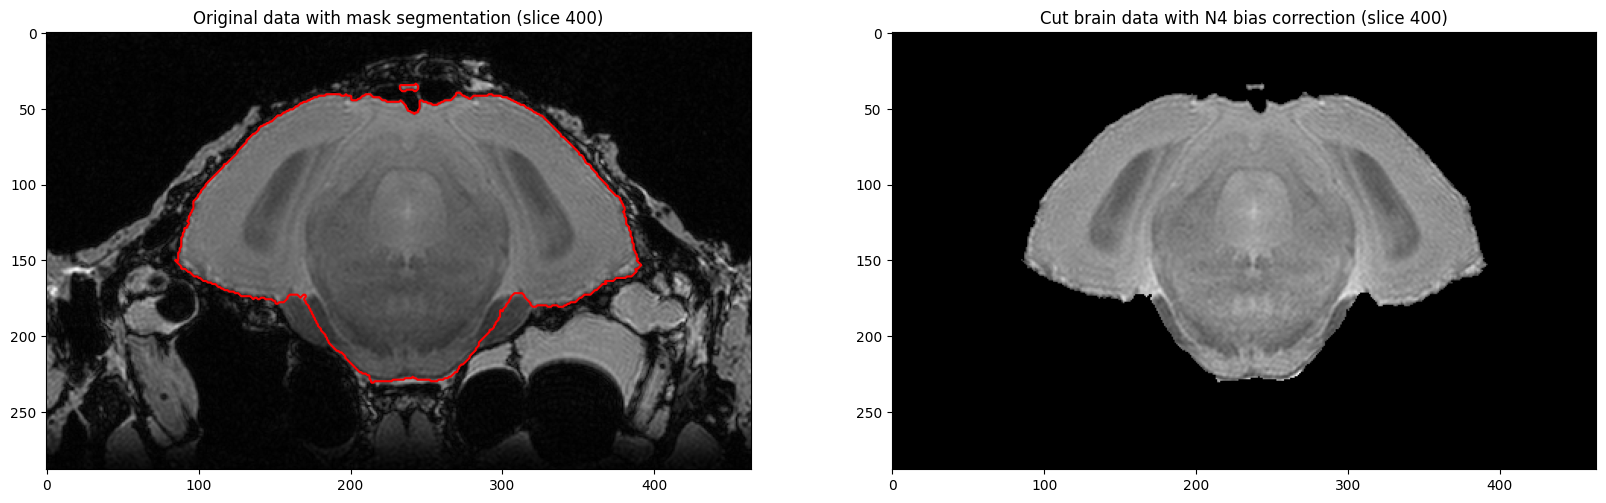

In [21]:
IDX = 400

f, ax = plt.subplots(1, 2, figsize=(20, 10))
# Original slice
ax[0].imshow(original_data[IDX, :, :], cmap='gray')
ax[0].contour(segmentation[IDX, :, :], levels=[0.5], colors='r')
ax[0].set_title(f"Original data with mask segmentation (slice {IDX})")
# Processed slice
ax[1].imshow(data[IDX, :, :], cmap='gray')
ax[1].set_title(f"Cut brain data with N4 bias correction (slice {IDX})")
plt.show()
f.clear()
plt.close(f)

## Load Waxholm atlas

In [10]:
atlas_label_path = 'data/Waxholm-Atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_atlas_v4.nii.gz'
atlas_FA_color_path = 'data/Waxholm-Atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_FA_color_v1.01.nii.gz'
atlas_T2_path = 'data/Waxholm-Atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_T2star_v1.01.nii.gz'

atlas_label = nib.load(atlas_label_path).get_fdata()
#atlas_FA_color = nib.load(atlas_FA_color_path).get_fdata()
atlas_T2 = nib.load(atlas_T2_path).get_fdata()

# Reorient to make coronal view the first index
atlas_label = np.transpose(atlas_label, (1, 0, 2))
#atlas_FA_color = np.transpose(atlas_FA_color, (1, 2, 0))
atlas_T2 = np.transpose(atlas_T2, (1, 0, 2))

# Rotate the image rightside-up
atlas_label = np.rot90(atlas_label, k=1, axes=(1, 2))
atlas_T2 = np.rot90(atlas_T2, k=1, axes=(1, 2))

# Flip the coronal axis
atlas_label = np.flip(atlas_label, axis=0)
atlas_T2 = np.flip(atlas_T2, axis=0)

# Process label segmentation
atlas_mask = atlas_label != 0
atlas_mask = atlas_mask.astype(bool)
atlas_mask = remove_small_holes(atlas_mask, area_threshold=10000, connectivity=1)

# Apply N4 bias field correction
atlas_T2 = n4_bias_correction(atlas_T2, atlas_mask, shrink_factor=4, show=False)

# Segment from background
atlas_data = np.where(atlas_mask, atlas_T2, 0)

# Make compressed version for registration test
atlas_compressed = atlas_data.copy()[::2, :, :]

print("Atlas volume shape:", atlas_data.shape)
print("Atlas volume data type:", atlas_data.dtype)
print("Atlas min value:", atlas_data.min())
print("Atlas max value:", atlas_data.max())

#np.save('data/waxholm.npy', atlas_data)
#np.save('data/waxholm_compressed.npy', atlas_compressed)

Atlas volume shape: (1024, 512, 512)
Atlas volume data type: float64
Atlas min value: 0.0
Atlas max value: 64398.88029465268


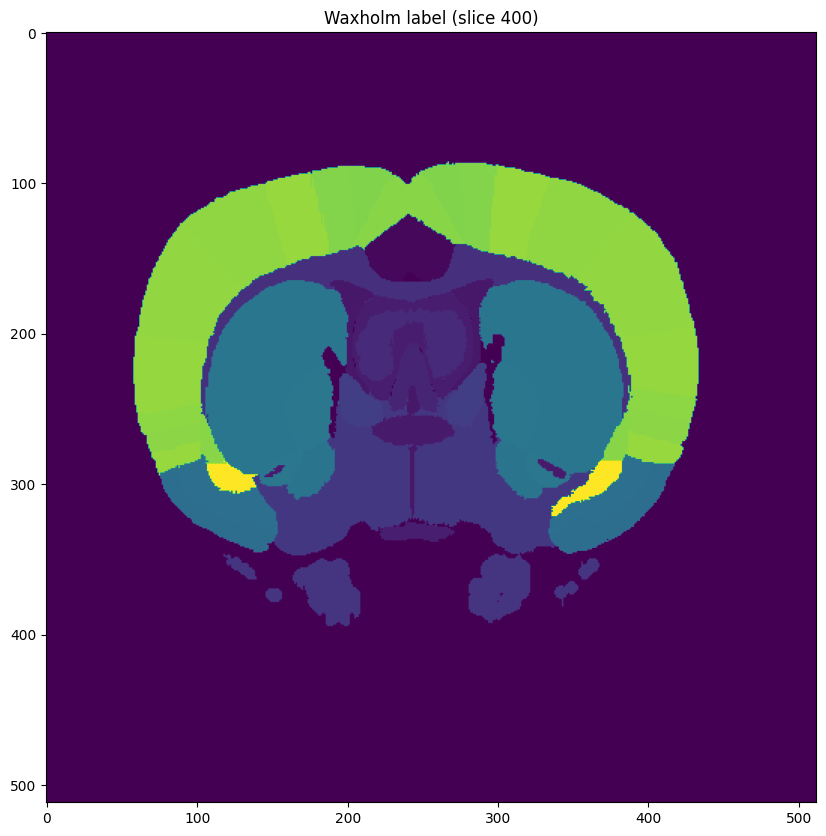

In [ ]:
atlas_label_path = 'data/Waxholm-Atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_atlas_v4.nii.gz'
atlas_label = nib.load(atlas_label_path).get_fdata()
#atlas_FA_color = nib.load(atlas_FA_color_path).get_fdata()
atlas_T2 = nib.load(atlas_T2_path).get_fdata()

# Reorient to make coronal view the first index
atlas_label = np.transpose(atlas_label, (1, 0, 2))
#atlas_FA_color = np.transpose(atlas_FA_color, (1, 2, 0))
atlas_T2 = np.transpose(atlas_T2, (1, 0, 2))

# Rotate the image rightside-up
atlas_label = np.rot90(atlas_label, k=1, axes=(1, 2))
atlas_T2 = np.rot90(atlas_T2, k=1, axes=(1, 2))

# Flip the coronal axis
atlas_label = np.flip(atlas_label, axis=0)



60, 180, 220, 245, 280, 340

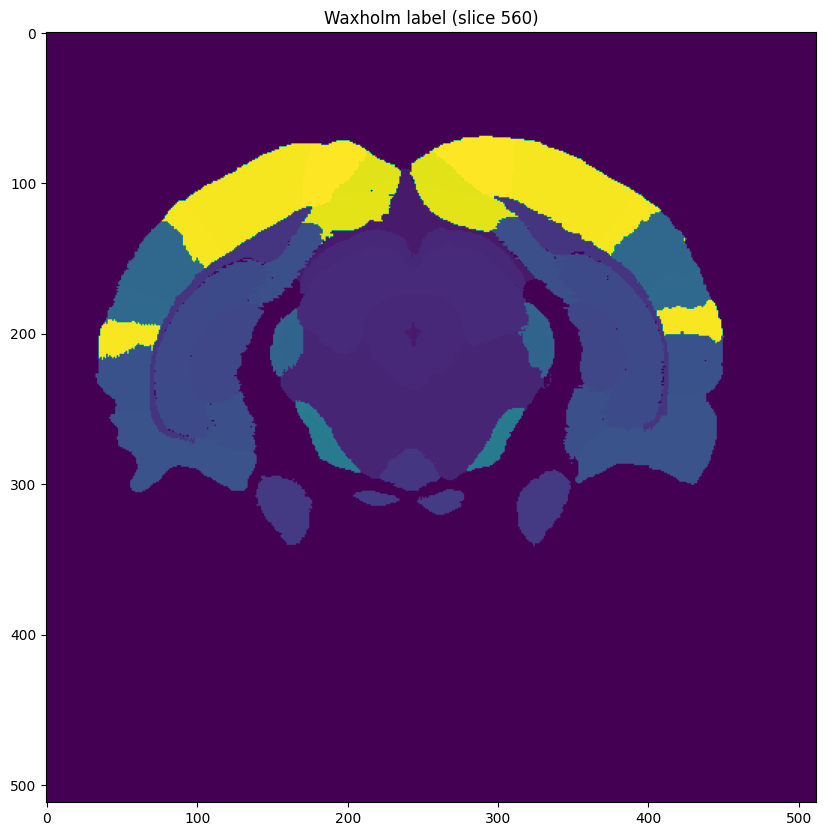

In [27]:
IDX = 560
f = plt.figure(figsize=(10, 10))
plt.imshow(atlas_label[IDX, :, :])
plt.title(f"Waxholm label (slice {IDX})")
plt.show()

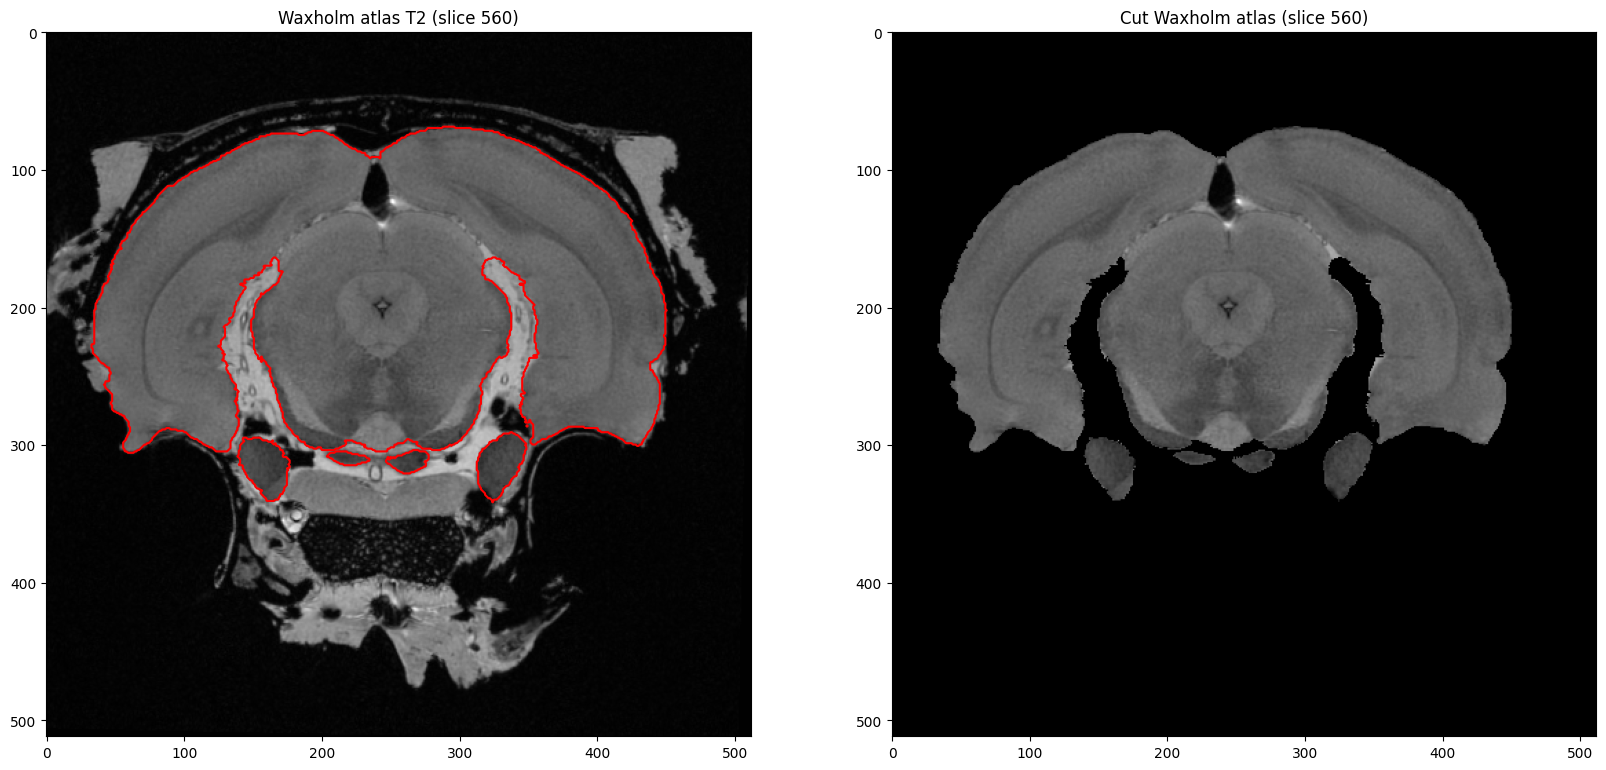

In [15]:
#IDX = 120 # 440
#IDX = 360
#IDX = 420
#IDX = 490
IDX = 560
#IDX = 680

# T2 atlas
f, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(atlas_T2[IDX, :, :], cmap='gray')
ax[0].contour(atlas_mask[IDX, :, :], levels=[0.5], colors='r')
ax[0].set_title(f"Waxholm atlas T2 (slice {IDX})")
ax[1].imshow(atlas_data[IDX, :, :], cmap='gray')
ax[1].set_title(f"Cut Waxholm atlas (slice {IDX})")
plt.show()
f.clear()
plt.close(f)

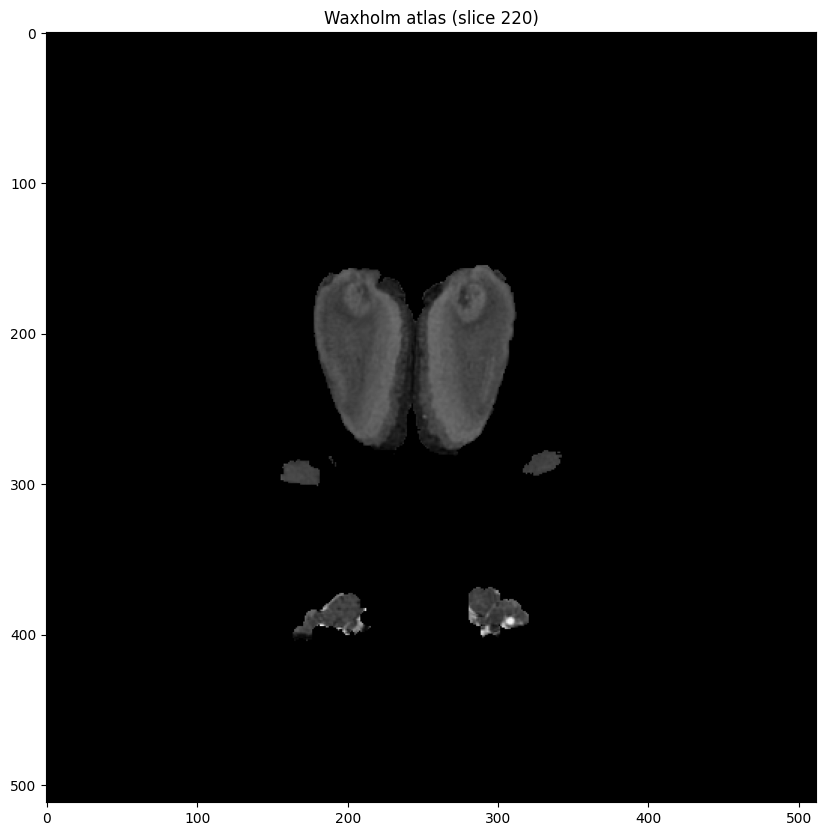

In [7]:
IDX = 220

# T2 atlas
f = plt.figure(figsize=(10, 10))
plt.imshow(atlas_data[IDX, :, :], cmap='gray')
plt.title(f"Waxholm atlas (slice {IDX})")
plt.show()
f.clear()
plt.close(f)

## Use ANTs registration

In [1]:
import numpy as np

data = np.load('output/processed/degu_191.npy')
atlas_data = np.load('output/processed/waxholm.npy')

In [2]:
import ants

output_path = "output/registered/ants_atlas_to_degu_191.nii.gz"

# Run code
print("Converting arrays to ANTs format...")
moving_image = ants.from_numpy(data)
fixed_image = ants.from_numpy(atlas_data)

#moving_image = ants.from_numpy(atlas_data)
#fixed_image = ants.from_numpy(data)

print("Registering...")
result = ants.registration(fixed_image, moving_image, type_of_transform = 'SyN' )

print("Saving to", output_path)

# Save Moving image warped to space of fixed image
#ants.image_write(result['warpedmovout'], output_path)
# Fixed image warped to space of moving image
ants.image_write(result['warpedfixout'], output_path)

print("Done!")

Converting arrays to ANTs format...
Registering...
Saving to output/registered/ants_atlas_to_degu_191.nii.gz
Done!


In [10]:
import shutil
import os

# Save forward transforms
for i, fwd_transform in enumerate(result['fwdtransforms']):
    shutil.copy(fwd_transform, f"output/registered/transforms/degu_191_fwd_{os.path.basename(fwd_transform)}")

# Save inverse transforms
for i, inv_transform in enumerate(result['invtransforms']):
    shutil.copy(inv_transform, f"output/registered/transforms/degu_191_inv_{os.path.basename(inv_transform)}")

print("Transforms copied successfully.")

Transforms copied successfully.


In [9]:
# Transforms to move from moving to fixed image
print(result['fwdtransforms'])
# Transforms to move from fixed to moving image
print(result['invtransforms'])

['/tmp/tmpao0xre8g1Warp.nii.gz', '/tmp/tmpao0xre8g0GenericAffine.mat']
['/tmp/tmpao0xre8g0GenericAffine.mat', '/tmp/tmpao0xre8g1InverseWarp.nii.gz']


Result volume shape: (512, 512, 512)


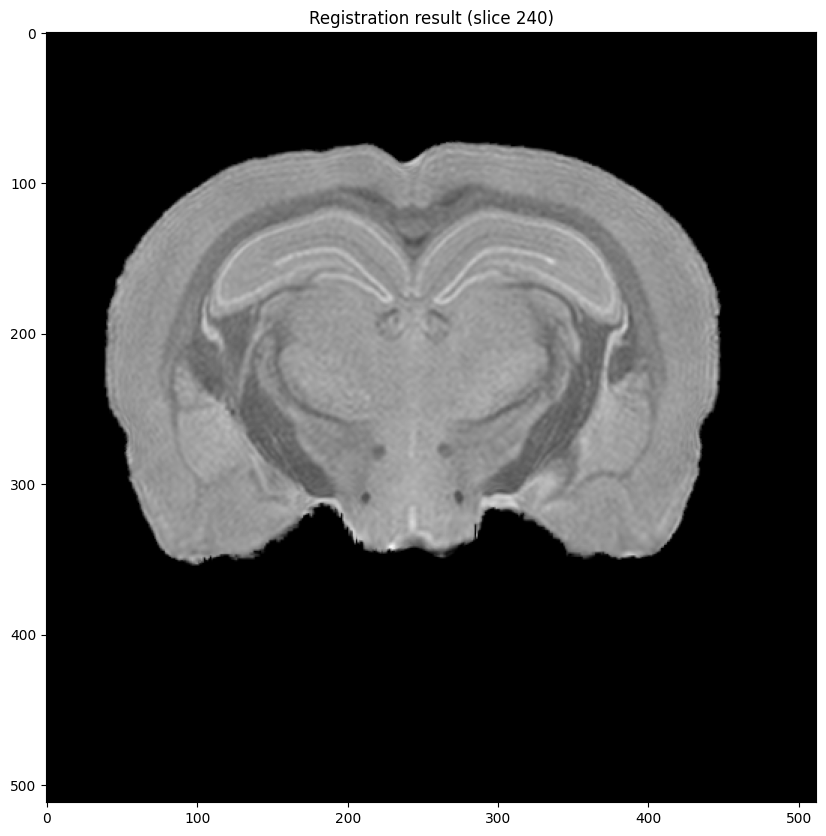

In [ ]:
IDX = 240
output_path = "output/registered/ants_degu_191_compressed.nii.gz"

# View the result
result_data = nib.load(output_path).get_fdata()
print("Result volume shape:", result_data.shape)

# Registered result
f = plt.figure(figsize=(10, 10))
plt.imshow(result_data[IDX, :, :], cmap='gray')
plt.title(f"Registration result (slice {IDX})")
plt.show()
f.clear()
plt.close(f)

Original shape: (592, 288, 464)
Registered shape: (592, 288, 464)


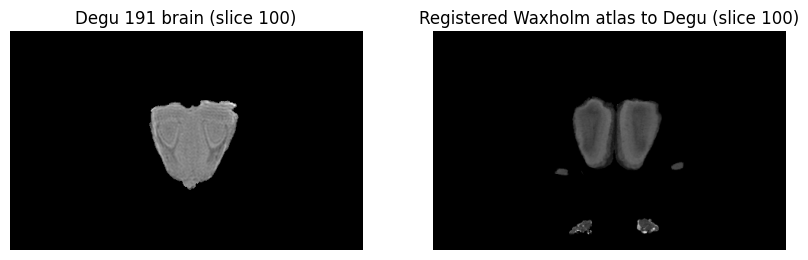

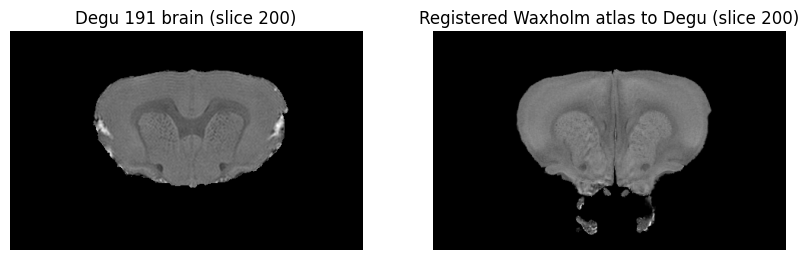

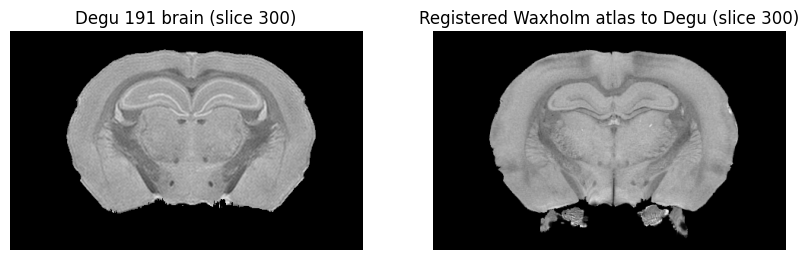

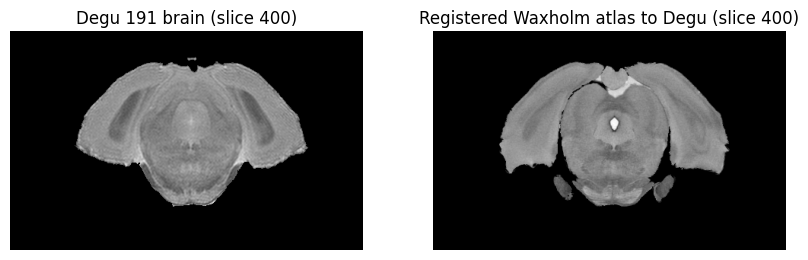

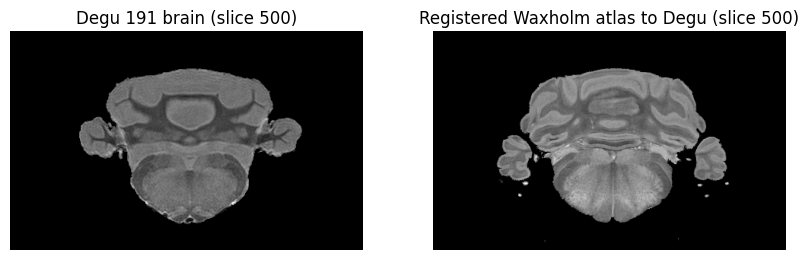

In [25]:
import nibabel as nib 
import matplotlib.pyplot as plt

IDX = 400

output_path = "output/registered/ants_atlas_to_degu_191.nii.gz"
# View the result
result_data = nib.load(output_path).get_fdata()

print("Original shape:", data.shape)
print("Registered shape:", result_data.shape)

def show_reg_plots(idx, data, result_data):
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    # moving_image
    ax[0].imshow(data[idx, :, :], cmap='gray')
    ax[0].set_title(f"Degu 191 brain (slice {idx})")
    ax[0].set_axis_off()
    ax[1].imshow(result_data[idx, :, :], cmap='gray')
    ax[1].set_title(f"Registered Waxholm atlas to Degu (slice {idx})")
    ax[1].set_axis_off()
    plt.show()
    f.clear()
    plt.close(f)
    
show_reg_plots(100, data, result_data)
show_reg_plots(200, data, result_data)
show_reg_plots(300, data, result_data)
show_reg_plots(400, data, result_data)
show_reg_plots(500, data, result_data)

## End

In [ ]:
print("Laplacian Refinement")
deformationField  = rg.sliceToSlice3DLaplacian(fixedImagePath , movingImagePath , axis =0 )
np.save(os.path.join(outputDir,"deformation3d.npy"), deformationField)
transformedData   = rg.applyDeformationField(movingImagePath , deformationField)
refinedResultPath = os.path.join(outputDir, "elastixRefined.nii.gz")
create_nifti_image(transformedData, 2.5, refinedResultPath, 1/2)

print("Final registered image stored at {}".format(refinedResultPath))

In [ ]:
print("START")
template_path = "processed/smartspim_25um_cropped.nii"
input_path0 = "240913_newscan/240913_new_scan_25downsampled_ch0.nii.gz"
input_path1 = "240913_newscan/240913_new_scan_25downsampled_ch1.nii.gz"
input_path2 = "240913_newscan/240913_new_scan_25downsampled_ch2.nii.gz"

output_path0 = "output/ch0_registered.nii.gz"
output_path1 = "output/ch1_registered.nii.gz"
output_path2 = "output/ch2_registered.nii.gz"

print("READING")

moving_image0 = nib.load(input_path0).get_fdata()
moving_image1 = nib.load(input_path1).get_fdata()
moving_image2 = nib.load(input_path2).get_fdata()
fixed_image = nib.load(template_path).get_fdata()


print("PROCESSING")
moving_image0 = np.rot90(moving_image0, k=1, axes=(1, 2))  # Ch0
moving_image0 = np.flip(moving_image0, axis=0)
moving_image1 = np.rot90(moving_image1, k=1, axes=(1, 2))  # Ch1
moving_image1 = np.flip(moving_image1, axis=0)
moving_image2 = np.rot90(moving_image2, k=1, axes=(1, 2))  # Ch2
moving_image2 = np.flip(moving_image2, axis=0)
fixed_image = np.moveaxis(fixed_image, -1, 0)



## Visualize

## Meeting notes

1. Paper with Eric

2. Dataset from Max 

3. Laplacian 
What is the size of the correspondence field size such that it can influence negative Jacobian? How do we pick the neighborhood size from there? 
Prediction: pattern matching with LUT values 
Prove this is a valid approach. 
Validity of lookup table. How do we prove that lookup table predicts negative and positive Jacobians correctly? 
Get a % accuracy rate on real data. Run comparison on real data and see how accurate the LUT is for all pairs. 

First, identify the negative Jacobian points


Next, how do we resolve negative Jacobian?
* Bin it 
* Remove it 
* Compute average

Prove that 
1. it solves the problem
2. It doesn't overdo things (false positives)
3. Why is it better? t does it efficiently. There is no other approach that can do it more efficiently than this. 
Advantages: highly parallelizable. 
Pick every two pairs of correspondence, send it to comparison machine, and it will tell you which ones are negative and which ones are positive.

Graduation plan: 
Send current list of publications and accepted / pending 
Future plan for next two three weeks that will result in a publication. 

import nibabel as nib
import imageio

# Load NIfTI file
nii = nib.load("../eric/data/mri/Xu-AAVretro-M4/Xu_AAVretro_M4_2hrs.nii.gz")
data = nii.get_fdata()

# Extract a slice (e.g., slice 100 in the first axis)
slice_idx = 10
slice_img = data[:, :, slice_idx]  # No normalization, raw values

# Save as TIFF (preserves raw float values if possible)
imageio.imwrite("output_slice.tif", slice_img)